<a href="https://colab.research.google.com/github/Blvisse/Breast-Cancer-Causality/blob/modelling/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dowhy

     |████████████████████████████████| 123 kB 5.2 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [ ]:
!pip install dvc

In [11]:
import dowhy
import pandas as pd
import numpy as np
import seaborn as sns
from dowhy import CausalModel
from IPython.display import Image,display
# import dvc.api


# ha=dvc.api.get_url('data/data.csv','https://github.com/Blvisse/Breast-Cancer-Causality.git','data-v1')
# h=pd.read_csv(ha)

data=pd.read_csv('/content/final_data.csv')

In [4]:
data

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,20.57,17.77,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,0,19.69,21.25,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,0,20.29,14.34,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
3,0,12.45,15.70,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
4,0,18.25,19.98,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,1,14.05,27.15,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.4920,0.007256,0.02678,0.02071,0.01626,0.02080,0.005304,15.30,33.17,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321
491,0,20.92,25.09,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,0.9622,1.0260,0.006399,0.04310,0.07845,0.02624,0.02057,0.006213,24.29,29.41,0.1407,0.4186,0.6599,0.2542,0.2929,0.09873
492,0,21.56,22.39,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.40,0.1410,0.2113,0.4107,0.2216,0.2060,0.07115
493,0,20.13,28.25,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.69,38.25,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637


# Hypothesis Testing

1. Higher Radius converts to a malignant diagnosis
2. Smoother mean interprates to a begning diagnosis
3. High concativity is associated to a malignant diagnosis
4. Higher mean values are more crucial than standard error and worst readings

Would high radius_mean readings affect the diagnosis?

In [5]:
data['radius_mean'].describe()

count    495.000000
mean      13.868883
std        3.042868
min        6.981000
25%       11.745000
50%       13.210000
75%       15.290000
max       23.270000
Name: radius_mean, dtype: float64

We define a high raius mean reading as anything above the 75 percentile reading 

In [6]:
data['high_radius_mean']=data['radius_mean'].apply(lambda x: True if x > 15.3 else False)

In [7]:
data

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,high_radius_mean
0,0,20.57,17.77,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,True
1,0,19.69,21.25,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,True
2,0,20.29,14.34,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,True
3,0,12.45,15.70,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,False
4,0,18.25,19.98,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,1,14.05,27.15,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.4920,0.007256,0.02678,0.02071,0.01626,0.02080,0.005304,15.30,33.17,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321,False
491,0,20.92,25.09,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,0.9622,1.0260,0.006399,0.04310,0.07845,0.02624,0.02057,0.006213,24.29,29.41,0.1407,0.4186,0.6599,0.2542,0.2929,0.09873,True
492,0,21.56,22.39,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.40,0.1410,0.2113,0.4107,0.2216,0.2060,0.07115,True
493,0,20.13,28.25,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.69,38.25,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637,True


Create dataframe with a fraction of our data which we are interesetd with

In [8]:
mean_training=data[['diagnosis','high_radius_mean','compactness_mean','concave points_mean','radius_mean','fractal_dimension_mean','concavity_mean']].copy()

In [9]:
mean_training

,diagnosis,high_radius_mean,compactness_mean,concave points_mean,radius_mean,fractal_dimension_mean,concavity_mean
0,0,True,0.07864,0.07017,20.57,0.05667,0.08690
1,0,True,0.15990,0.12790,19.69,0.05999,0.19740
2,0,True,0.13280,0.10430,20.29,0.05883,0.19800
3,0,False,0.17000,0.08089,12.45,0.07613,0.15780
4,0,True,0.10900,0.07400,18.25,0.05742,0.11270
...,...,...,...,...,...,...,...
490,1,False,0.11260,0.04304,14.05,0.06171,0.04462
491,0,True,0.22360,0.14740,20.92,0.06879,0.31740
492,0,True,0.11590,0.13890,21.56,0.05623,0.24390
493,0,True,0.10340,0.09791,20.13,0.05533,0.14400


1. High radius mean might affect the diagnosis outcome, high radius mean is associated with malignant cells
2. Fractal dimension affects the smoothness of  a cell,
3. Radius of the cell might affect the smoothness of a cell which in its part might affect the nature of the cell.
4. radius also affects th compactness of a cell with a higher radius resulting into a lower compactness degree. This affects the nature of the cell as well 

In [10]:
#the causal graph
causal_graph= """
digraph {

diagnosis;me
 high_radius_mean;
 compactness_mean;
 concave points_mean;
 radius_mean;
 fractal_dimension_mean;
 concavity_mean;
 U[label="Unobserved Confounders"];
 radius_mean->compactness_mean; 
 concave points_mean ->concavity_mean;
 radius_mean->high_radius_mean;
 compactness_mean->concavity_mean;
 U->diagnosis;U->radius_mean;U->high_radius_mean;
 high_radius_mean->diagnosis;radius_mean->diagnosis;










}







"""

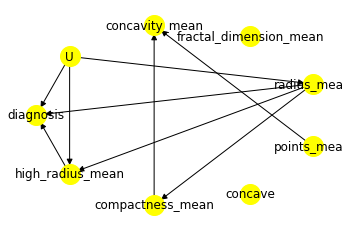

In [13]:
#we now create a causal model based on the diagraph above
model=CausalModel(data=mean_training,graph=causal_graph.replace("\n"," "),treatment='high_radius_mean',outcome='diagnosis')
model.view_model()

### Identifying Causal effect

In [14]:
effect=model.identify_effect()
print(effect)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
───────────────────(Expectation(diagnosis|fractal_dimension_mean,compactness_m
d[high_radius_mean]                                                           

                                
ean,radius_mean,concavity_mean))
                                
Estimand assumption 1, Unconfoundedness: If U→{high_radius_mean} and U→diagnosis then P(diagnosis|high_radius_mean,fractal_dimension_mean,compactness_mean,radius_mean,concavity_mean,U) = P(diagnosis|high_radius_mean,fractal_dimension_mean,compactness_mean,radius_mean,concavity_mean)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [15]:
#using the propensity score based inverse weighting 
estimate=model.estimate_effect(effect,method_name="backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
───────────────────(Expectation(diagnosis|fractal_dimension_mean,compactness_m
d[high_radius_mean]                                                           

                                
ean,radius_mean,concavity_mean))
                                
Estimand assumption 1, Unconfoundedness: If U→{high_radius_mean} and U→diagnosis then P(diagnosis|high_radius_mean,fractal_dimension_mean,compactness_mean,radius_mean,concavity_mean,U) = P(diagnosis|high_radius_mean,fractal_dimension_mean,compactness_mean,radius_mean,concavity_mean)

## Realized estimand
b: diagnosis~high_radius_mean+fractal_dimension_mean+compactness_mean+radius_mean+concavity_mean
Target units: ate

## Estimate
Mean value: -0.6756438222395568



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


From this we can interprate that the probability of being a benign cell is decreased by -.67 % if the cell has a higher mean radius 

## Refuting an obtained estimate

### Random Common Cause

In [16]:
#validating our assumption

verify=model.refute_estimate(effect,estimate,"random_common_cause")
print(verify)

Refute: Add a Random Common Cause
Estimated effect:-0.6756438222395568
New effect:-0.6761790077548765



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Data Subset Refuter

In [ ]:
#repplacing with a randomly selected subset
refutel=model.refute_estimate(effect,estimate,"data_subset_refuter")
print(refutel)

There wasn't a huge change in our new effect verifying that our findings aren't prone to randomness

### Placebo Treatment

In [ ]:
refute=model.refute_estimate(effect,estimate,"placebo_treatment_refuter")
print(refute)

With this we can conclude that our assumption was correct:

 **High radius_mean has a causal effect on the diagnosis**

## Does high concativity_mean reading affect the diagnosis 

In [ ]:
data.describe()

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000
mean,0.670707,13.868883,18.889778,0.095075,0.094741,0.074145,0.043306,0.177602,0.061779,0.365332,1.152375,0.006765,0.022127,0.027017,0.010931,0.019372,0.003331,15.846776,25.152343,0.130829,0.231213,0.240894,0.106625,0.283788,0.081467
std,0.470432,3.042868,3.966250,0.012822,0.041071,0.061694,0.032550,0.023258,0.005546,0.204313,0.460740,0.002450,0.012662,0.017689,0.004836,0.006103,0.001610,4.130793,5.666008,0.021069,0.125632,0.171007,0.058203,0.049675,0.014411
min,0.000000,6.981000,9.710000,0.062510,0.019380,0.000000,0.000000,0.116700,0.049960,0.114400,0.360200,0.002667,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,0.081250,0.034320,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.745000,16.000000,0.085345,0.062310,0.027420,0.019485,0.160800,0.057490,0.224400,0.809500,0.005057,0.012540,0.014420,0.007423,0.014930,0.002155,13.055000,20.845000,0.115950,0.140000,0.106450,0.063060,0.248750,0.070830
50%,1.000000,13.210000,18.580000,0.094620,0.085490,0.053080,0.030700,0.177100,0.061150,0.303100,1.068000,0.006175,0.018850,0.023220,0.010430,0.018420,0.002968,14.800000,25.110000,0.130100,0.203100,0.195600,0.092220,0.278500,0.078750
75%,1.000000,15.290000,21.460000,0.103700,0.120150,0.107250,0.062770,0.193000,0.065105,0.428750,1.417000,0.007975,0.029720,0.037250,0.013700,0.022130,0.004125,17.730000,28.900000,0.143600,0.305050,0.349200,0.148950,0.311300,0.089850
max,1.000000,23.270000,30.720000,0.137100,0.228400,0.317400,0.156200,0.254000,0.079760,1.214000,2.643000,0.016040,0.074710,0.111400,0.028530,0.044990,0.011300,28.190000,41.610000,0.190900,0.664300,0.848900,0.270100,0.475300,0.134100


In [ ]:
data['concant_mean_bin']=data['concavity_mean'].apply(lambda x: 'h' if x > 0.07 else False)

In [ ]:
data

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,concant_mean_bin
0,0,20.57,17.77,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,True
1,0,19.69,21.25,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,True
2,0,20.29,14.34,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,True
3,0,12.45,15.70,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,True
4,0,18.25,19.98,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,1,14.05,27.15,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.4920,0.007256,0.02678,0.02071,0.01626,0.02080,0.005304,15.30,33.17,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321,False
491,0,20.92,25.09,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,0.9622,1.0260,0.006399,0.04310,0.07845,0.02624,0.02057,0.006213,24.29,29.41,0.1407,0.4186,0.6599,0.2542,0.2929,0.09873,True
492,0,21.56,22.39,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.40,0.1410,0.2113,0.4107,0.2216,0.2060,0.07115,True
493,0,20.13,28.25,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.69,38.25,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637,True


In [ ]:
train=data[['diagnosis','concant_mean_bin','compactness_mean','concave points_mean','radius_mean']]

In [ ]:
causal_graph=""" digraph
{
        
     diagnosis;
     concant_mean_bin;
     compactness_mean;
     concave points_mean;
     radius_mean;
     U[label = "Unobserved confounders"];
     compactness_mean->concant_mean_bin; concave points_mean->compactness_mean;radius_mean->concave points_mean; radius_mean->diagnosis;
     compactness_mean->diagnosis; U->concant_mean_bin;concant_mean_bin->diagnosis





    }

    """

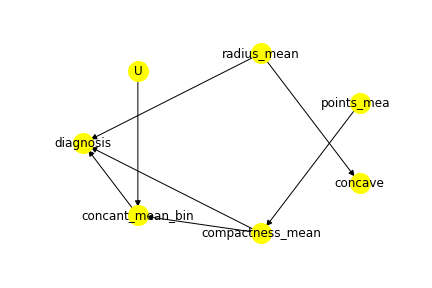

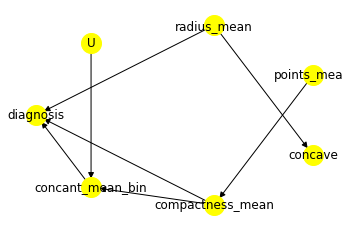

In [ ]:
from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = train,
        graph=causal_graph.replace("\n", " "),
        treatment='concant_mean_bin',
        outcome='diagnosis')
model.view_model()
display(Image(filename="causal_model.png"))


In [ ]:
#Identify the causal effect
estimands = model.identify_effect()
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                              
───────────────────(Expectation(diagnosis|compactness_mean,radius_mean))
d[concant_mean_bin]                                                     
Estimand assumption 1, Unconfoundedness: If U→{concant_mean_bin} and U→diagnosis then P(diagnosis|concant_mean_bin,compactness_mean,radius_mean,U) = P(diagnosis|concant_mean_bin,compactness_mean,radius_mean)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(diagnosis, [U])*Derivative([concant_mean_bin], [U])**(-
1))
Estimand assumption 1, As-if-random: If U→→diagnosis then ¬(U →→{U})
Estimand assumption 2, Exclusion: If we remove {U}→{concant_mean_bin}, then ¬({U}→diagnosis)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [ ]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                              
───────────────────(Expectation(diagnosis|compactness_mean,radius_mean))
d[concant_mean_bin]                                                     
Estimand assumption 1, Unconfoundedness: If U→{concant_mean_bin} and U→diagnosis then P(diagnosis|concant_mean_bin,compactness_mean,radius_mean,U) = P(diagnosis|concant_mean_bin,compactness_mean,radius_mean)

## Realized estimand
b: diagnosis~concant_mean_bin+compactness_mean+radius_mean
Target units: ate

## Estimate
Mean value: -0.3062271682105436



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data['ps'] = self._propensity_score_model.predict_proba(self._observed_common_causes)[:,1]
/usr/local/lib/python3.7/dist-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

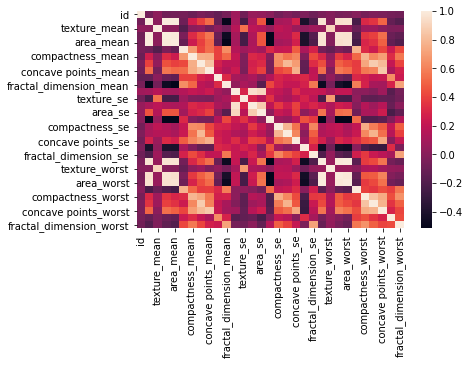

In [ ]:
sns.heatmap(data.corr())

In [ ]:
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,8510426,B,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,0.05766,0.2699,0.7886,2.058,23.56,0.008462,0.014600,0.02387,0.013150,0.01980,0.002300,15.110,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259
1,8510653,B,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,0.1967,0.06811,0.1852,0.7477,1.383,14.67,0.004097,0.018980,0.01698,0.006490,0.01678,0.002425,14.500,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183
2,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905,0.2773,0.9768,1.909,15.70,0.009606,0.014320,0.01985,0.014210,0.02027,0.002968,10.230,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773
3,854941,B,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,0.1839,2.3420,1.170,14.16,0.004352,0.004899,0.01343,0.011640,0.02671,0.001777,13.300,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169
4,855167,M,13.440,21.58,86.18,563.0,0.08162,0.06031,0.03110,0.02031,0.1784,0.05587,0.2385,0.8265,1.572,20.53,0.003280,0.011020,0.01390,0.006881,0.01380,0.001286,15.930,30.25,102.50,787.9,0.10940,0.20430,0.20850,0.11120,0.2994,0.07146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,923748,B,10.860,21.48,68.51,360.5,0.07431,0.04227,0.00000,0.00000,0.1661,0.05948,0.3163,1.3040,2.115,20.67,0.009579,0.011040,0.00000,0.000000,0.03004,0.002228,11.660,24.77,74.08,412.3,0.10010,0.07348,0.00000,0.00000,0.2458,0.06592
243,923780,B,11.130,22.44,71.49,378.4,0.09566,0.08194,0.04824,0.02257,0.2030,0.06552,0.2800,1.4670,1.994,17.85,0.003495,0.030510,0.03445,0.010240,0.02912,0.004723,12.020,28.26,77.80,436.6,0.10870,0.17820,0.15640,0.06413,0.3169,0.08032
244,924632,B,12.880,28.92,82.50,514.3,0.08123,0.05824,0.06195,0.02343,0.1566,0.05708,0.2116,1.3600,1.502,16.83,0.008412,0.021530,0.03898,0.007620,0.01695,0.002801,13.890,35.74,88.84,595.7,0.12270,0.16200,0.24390,0.06493,0.2372,0.07242
245,925292,B,14.050,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.4920,2.888,29.84,0.007256,0.026780,0.02071,0.016260,0.02080,0.005304,15.300,33.17,100.20,706.7,0.12410,0.22640,0.13260,0.10480,0.2250,0.08321


In [ ]:
model=CausalModel(
        data = data,
        treatment='radius_mean',
        outcome='diagnosis',
        
        )

WARN: Are you sure that there are no common causes of treatment and outcome? [y/n] y


In [ ]:
identified_estimand=model.identify_effect()

AttributeError: ignored

In [ ]:
!pip install causalgraphicalmodels

In [ ]:
from causalgraphicalmodels import CausalGraphicalModel

In [ ]:
effect=CausalGraphicalModel(nodes=data.columns,edges=[
          ("radius_mean","diagnosis"),
          ("texture_mean","diagnosis"),
          ("smoothness_mean","diagnosis"),
          ("smoothness_mean","radius_mean"),
          ("compactness_mean","diagnosis"),
          ("concavity_mean","diagnosis"),
          ("concave points_mean","diagnosis"),
          ("symmetry_mean","diagnosis"),
          ("fractal_dimesnion_mean","diagnosis"),
          ("radius_worst","diagnosis"),
          ("texture_worst","diagnosis"),
          ("smoothness_worst","diagnosis"),
          ("smoothness_worst","radius_worst"),
          ("compactness_worst","diagnosis"),
          ("concavity_worst","diagnosis"),
          ("concave points_worst","diagnosis"),
          ("symmetry_worst","diagnosis"),
          ("fractal_dimesnion_worst","diagnosis"),
          ("radius_se","diagnosis"),
          ("texture_se","diagnosis"),
          ("smoothness_se","diagnosis"),
          ("smoothness_se","radius_se"),
          ("compactness_se","diagnosis"),
          ("concavity_se","diagnosis"),
          ("concave points_se","diagnosis"),
          ("symmetry_se","diagnosis"),
          ("fractal_dimesnion_se","diagnosis"),
          ("compactness_se","diagnosis"),
          ("fractal_dimesnion_se","diagnosis"),
          ("perimeter_se","diagnosis")
                                            
        ])

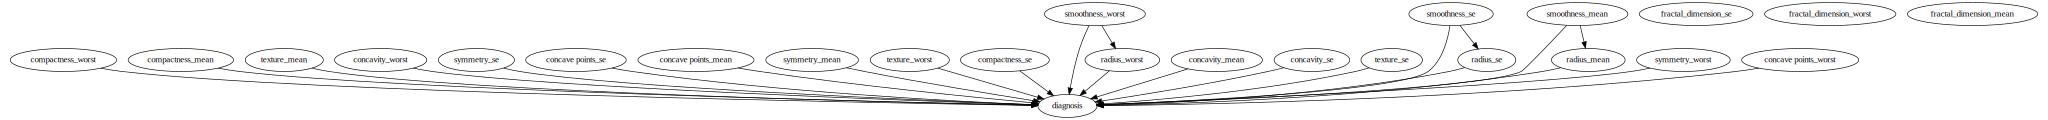

In [ ]:
effect.draw()

In [ ]:
print(effect.get_distribution())

P(texture_mean)P(smoothness_mean)P(compactness_mean)P(concavity_mean)P(concave points_mean)P(symmetry_mean)P(fractal_dimension_mean)P(texture_se)P(smoothness_se)P(compactness_se)P(concavity_se)P(concave points_se)P(symmetry_se)P(fractal_dimension_se)P(texture_worst)P(smoothness_worst)P(compactness_worst)P(concavity_worst)P(concave points_worst)P(symmetry_worst)P(fractal_dimension_worst)P(fractal_dimesnion_mean)P(fractal_dimesnion_worst)P(fractal_dimesnion_se)P(perimeter_se)P(radius_mean|smoothness_mean)P(radius_se|smoothness_se)P(radius_worst|smoothness_worst)P(diagnosis|radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimesnion_mean,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimesnion_worst,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimesnion_se,perimeter_se)


In [ ]:
effect.get_all_independence_relationships()

In [ ]:
model=CausalModel(
        data = data,
        treatment='radius_worst',
        outcome='diagnosis',
        
        )

WARN: Are you sure that there are no common causes of treatment and outcome? [y/n] y


In [ ]:
identified_estimand = model.identify_effect()

AttributeError: ignored

In [ ]:
data

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,20.57,17.77,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,0,19.69,21.25,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,0,20.29,14.34,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
3,0,12.45,15.70,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
4,0,18.25,19.98,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,1,14.05,27.15,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.4920,0.007256,0.02678,0.02071,0.01626,0.02080,0.005304,15.30,33.17,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321
491,0,20.92,25.09,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,0.9622,1.0260,0.006399,0.04310,0.07845,0.02624,0.02057,0.006213,24.29,29.41,0.1407,0.4186,0.6599,0.2542,0.2929,0.09873
492,0,21.56,22.39,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.40,0.1410,0.2113,0.4107,0.2216,0.2060,0.07115
493,0,20.13,28.25,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.69,38.25,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637


## Assumptions 